In [9]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, DataStore
from gammapy.datasets import MapDataset, Datasets
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

In [2]:
# Loading IRFs
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs=datastore.obs(26850)
irfs = {"aeff": obs.aeff,
       "psf": obs.psf,
       "edisp": obs.edisp,
       "bkg": obs.bkg}

No HDU found matching: OBS_ID = 26850, HDU_TYPE = rad_max, HDU_CLASS = None


In [3]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 100.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

# Define map geometry for binned simulation
energy_reco = MapAxis.from_energy_bounds(energy_min=500*u.GeV, energy_max=10*u.TeV,
                                        nbin=6, per_decade=True, name="energy")

geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(4, 4),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_energy_bounds(energy_min=100*u.GeV, energy_max=20*u.TeV,
                                        nbin=12, per_decade=True, name="energy_true")




In [5]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.4 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
bkg_model.parameters["norm"].value=0.99

models = Models([model_simu, bkg_model])

In [16]:
models_simulated = models.copy()

In [80]:
def simulate(name="dataset-simu"):
    empty = MapDataset.create(
        geom, name=name, energy_axis_true=energy_true
    )
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.0 * u.deg)

    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = models
    dataset.fake()
    return dataset


In [81]:
datasets = []
for i in range(20):
    dataset = simulate(name=f"dataset_{i}")
    datasets.append(dataset)

In [82]:
Datasets(datasets).info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str10,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
stacked,227108,226940.265625,167.734375,0.3520568590525765,226940.30122452974,226940.265625,nan,677391232.0,90755760128.0,360000.0,360000.0,0.6308555555555555,0.6303896267361111,0.00046592881944444443,320000,251424,cash,nan
dataset_1,228057,226940.30122008003,1116.6987799199705,2.3422035815801503,228107.04952427663,226940.30122008003,1166.7483041966352,677391245.0318525,90755763507.02928,360000.0,360000.0,0.6334916666666667,0.6303897256113334,0.0031019410553332514,320000,251424,cash,311078.4180643058
dataset_2,227267,226940.30122008003,326.69877991997055,0.6856264274716187,228107.04952427663,226940.30122008003,1166.7483041966352,677391245.0318525,90755763507.02928,360000.0,360000.0,0.6312972222222222,0.6303897256113334,0.000907496610888807,320000,251424,cash,311370.26469202474
dataset_3,228595,226940.30122008003,1654.6987799199705,3.4692583831161774,228107.04952427663,226940.30122008003,1166.7483041966352,677391245.0318525,90755763507.02928,360000.0,360000.0,0.6349861111111111,0.6303897256113334,0.004596385499777696,320000,251424,cash,311303.16577117145
dataset_4,227751,226940.30122008003,810.6987799199705,1.7007694318555264,228107.04952427663,226940.30122008003,1166.7483041966352,677391245.0318525,90755763507.02928,360000.0,360000.0,0.6326416666666667,0.6303897256113334,0.0022519410553332514,320000,251424,cash,312651.0252264235
dataset_5,228090,226940.30122008003,1149.6987799199705,2.4113607036262836,228107.04952427663,226940.30122008003,1166.7483041966352,677391245.0318525,90755763507.02928,360000.0,360000.0,0.6335833333333334,0.6303897256113334,0.0031936077219999184,320000,251424,cash,311364.5382750818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dataset_14,228246,226940.30122008003,1305.6987799199705,2.7382401219760726,228107.04952427663,226940.30122008003,1166.7483041966352,677391245.0318525,90755763507.02928,360000.0,360000.0,0.6340166666666667,0.6303897256113334,0.0036269410553332517,320000,251424,cash,312349.6287460566


## Fitting

In [83]:
def fit_gauss(dataset):
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = bkg_model
    bkg_model.parameters["tilt"].frozen=False
    fit = Fit(optimize_opts={"print_level": 0})
    result = fit.run(datasets=[dataset])
    L0 = dataset.stat_sum()
    
    spatial_gauss = GaussianSpatialModel(frame="galactic")
    spatial_gauss.lat_0.min = -2
    spatial_gauss.lat_0.max = 2
    spatial_gauss.lon_0.max = 2
    spatial_gauss.lon_0.min = -2

    pwl = PowerLawSpectralModel()
    pwl.parameters["amplitude"].value = 1e-12
    model_gauss = SkyModel(spatial_model=spatial_gauss,
                           spectral_model=pwl, name="gauss")
    models = [model_gauss, bkg_model]
    dataset.models = models
    fit = Fit(optimize_opts={"print_level": 0})
    result = fit.run(datasets=[dataset])
    L1 = dataset.stat_sum()
    return L0-L1, result

In [84]:
def fit_disk(dataset):
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = bkg_model
    bkg_model.parameters["tilt"].frozen=False
    fit = Fit(optimize_opts={"print_level": 0})
    result = fit.run(datasets=[dataset])
    L0 = dataset.stat_sum()
    
    spatial_disk = DiskSpatialModel(frame="galactic")
    spatial_disk.lat_0.min = -2
    spatial_disk.lat_0.max = 2
    spatial_disk.lon_0.max = 2
    spatial_disk.lon_0.min = -2
    spatial_disk.parameters["r_0"].value=0.8
    
    pwl2 = PowerLawSpectralModel()
    pwl2.parameters["amplitude"].value = 1e-12
    model_disk = SkyModel(spatial_model=spatial_disk,
                           spectral_model=pwl2, name="gauss")
    models = [model_disk, bkg_model]
    dataset.models = models
    fit = Fit(optimize_opts={"print_level": 0})
    result = fit.run(datasets=[dataset])
    L1 = dataset.stat_sum()
    return L0-L1, result

In [85]:
from astropy.table import Table

In [86]:
table = Table(names=["dataset", 
                     "TS_Gauss", "ind_g", "ind_e_g", 
                     "amp_g", "amp_e_g", "sig_g", "sig_e_g",
                     "TS_Disk", "ind_d", "ind_e_d", 
                     "amp_d", "amp_e_d", "r_d", "r_e_d"],
             )
for i, ds in enumerate(datasets):
    TS_Gauss, res_gauss = fit_gauss(ds)
    TS_Disk, res_disk = fit_disk(ds)
    row = [i, 
           TS_Gauss, 
           res_gauss.parameters["index"].value,
           res_gauss.parameters["index"].error,
           res_gauss.parameters["amplitude"].value,
           res_gauss.parameters["amplitude"].error,
           res_gauss.parameters["sigma"].value,
           res_gauss.parameters["sigma"].error,
           TS_Disk, 
           res_disk.parameters["index"].value,
           res_disk.parameters["index"].error,
           res_disk.parameters["amplitude"].value,
           res_disk.parameters["amplitude"].error,
           res_disk.parameters["r_0"].value,
           res_disk.parameters["r_0"].error,
          ]
    print(row)
    table.add_row(row)

[0, 50.455287383287214, 2.8165482213370003, 0.25967092149166066, 1.8463580626051605e-12, 6.253110254891994e-13, 0.47118567956443635, 0.1123773952736626, 41.26165930344723, 2.8176694686985826, 0.2727169638156008, 1.3325543284518559e-12, 1.9251005001887756e-13, 0.7558200745450253, 0.007572912016049582]
[1, 9.82975863077445, 3.0511398982174534, 0.9001675010191345, 9.457146757476956e-13, 5.124168527849853e-13, 0.5366193512768449, 0.12728992162928662, 14.105402956658509, 3.105030128751378, 0.995597079934754, 9.077662506870466e-13, 4.1110501388009936e-13, 0.8591322802395243, 0.04111594563822877]
[2, 26.64678887539776, 3.6765290051845243, 0.5952779142626188, 1.0500016279926812e-12, 4.748567628321594e-13, 0.4797608170664014, 0.09313193536508069, 28.188054230471607, 3.81307062981603, 4.443334206238961, 7.672720291913438e-13, 1.9275168449103545e-12, 0.7417159155155817, 0.028412185326366135]
[3, 18.85544411931187, 3.390177479453394, 3.9628478187531844, 1.2309832016848361e-12, 3.388029954517795e-1

/Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/modeling/models/spatial.py:545: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)
/Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/modeling/models/spatial.py:545: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


ValueError: Can only stack equivalent maps or cutout of the same map.

In [87]:
table

dataset,TS_Gauss,ind_g,ind_e_g,amp_g,amp_e_g,sig_g,sig_e_g,TS_Disk,ind_d,ind_e_d,amp_d,amp_e_d,r_d,r_e_d
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,50.455287383287214,2.8165482213370003,0.25967092149166066,1.8463580626051605e-12,6.253110254891994e-13,0.47118567956443635,0.1123773952736626,41.26165930344723,2.8176694686985826,0.2727169638156008,1.3325543284518559e-12,1.9251005001887756e-13,0.7558200745450253,0.007572912016049582
1.0,9.82975863077445,3.0511398982174534,0.9001675010191345,9.457146757476956e-13,5.124168527849853e-13,0.5366193512768449,0.12728992162928662,14.105402956658509,3.105030128751378,0.995597079934754,9.077662506870466e-13,4.1110501388009936e-13,0.8591322802395243,0.04111594563822877
2.0,26.64678887539776,3.6765290051845243,0.5952779142626188,1.0500016279926812e-12,4.748567628321594e-13,0.4797608170664014,0.09313193536508069,28.188054230471607,3.81307062981603,4.443334206238961,7.672720291913438e-13,1.9275168449103545e-12,0.7417159155155817,0.028412185326366135
3.0,18.85544411931187,3.390177479453394,3.9628478187531844,1.2309832016848361e-12,3.388029954517795e-12,0.5571945727088425,0.35750098238559036,20.086708992661443,3.040675980505241,0.7401890427647548,9.431357645274222e-13,3.0641392699613474e-13,0.7864368901477767,0.02407785342183579
4.0,35.03215935261687,3.662730449043271,0.5712903429624584,9.286418045743118e-13,3.870391293254082e-13,0.38727393590863,0.0722089330414939,32.34798190364381,3.5654137850131162,0.5194775152239951,9.34363166513155e-13,2.621897514388164e-13,0.7455774898082876,0.02257058405166737
5.0,13.524289727618452,2.229699592675017,0.4873976631895105,3.204914220774762e-11,9.751016205824014e-11,0.963820145151885,0.9295720753773351,11.607063005445525,2.8066789556858875,0.7061702329055145,6.85361356610491e-13,2.2808430877137034e-13,0.7206283936000626,0.020250948532684783
6.0,14.650460798293352,3.5541547679882477,5.46985402478093,1.1266475443778796e-12,2.695225813044496e-12,0.5957711563968007,0.16455986415810736,15.704543832223862,2.306422231720164,0.32469482998108207,9.45937223169947e-13,2.4847130725004657e-13,0.8576224634577749,0.02110123434524515
7.0,24.659016863792203,3.457244800969593,0.6570890374313801,1.246654412403073e-12,6.236825579995172e-13,0.5210800945999637,0.11852830491549937,30.851232832763344,3.4600917367367168,0.9270830561480943,1.3677543699312256e-12,6.531023334751222e-13,0.970608237913507,0.017377831851729267
8.0,26.79241261439165,2.6252444699943687,0.3481021853590327,1.2702943889916639e-12,3.9761022958655795e-13,0.447236537697783,0.08867427904776758,25.059144485509023,2.443353094752271,0.29237817858699455,1.165020116994112e-12,2.376445890479885e-13,0.8317104465439631,0.010828623600422867


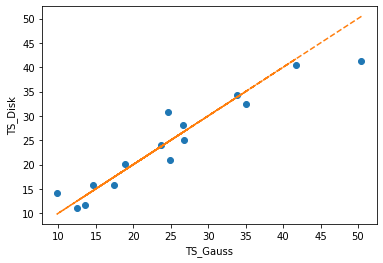

In [89]:
plt.plot(table["TS_Gauss"], table["TS_Disk"], "o")
plt.xlabel("TS_Gauss")
plt.ylabel("TS_Disk")
plt.plot(table["TS_Gauss"], table["TS_Gauss"], ls="--")

Text(0, 0.5, 'disk r0')

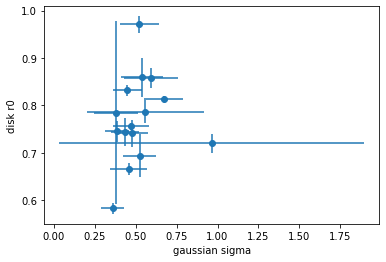

In [93]:
plt.errorbar(table["sig_g"], table["r_d"], 
            yerr=table["r_e_d"], xerr=table["sig_e_g"],
            fmt="o")
plt.xlabel("gaussian sigma")
plt.ylabel("disk r0")

Text(0, 0.5, 'index')

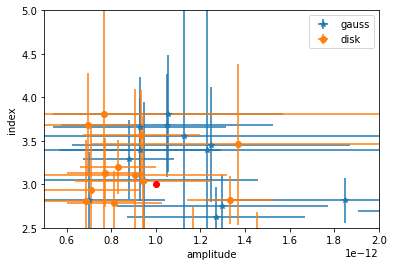

In [94]:
plt.errorbar(table["amp_g"], table["ind_g"], 
             xerr=table["amp_e_g"], yerr=table["ind_e_g"], fmt="*",
            label="gauss")
plt.errorbar(table["amp_d"], table["ind_d"], 
             xerr=table["amp_e_d"], yerr=table["ind_e_d"], fmt="o", 
            label="disk")
plt.ylim((2.5,5))
plt.xlim((0.5e-12, 2e-12))

plt.plot([spectral_model.parameters["amplitude"].value], 
         [spectral_model.parameters["index"].value],
         "o", color="red")
plt.legend()

plt.xlabel("amplitude")
plt.ylabel("index")